###  based on https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
print(torch.__version__)
print('CUDA available: ' + str(torch.cuda.is_available()))

1.2.0a0+8554416
CUDA available: True


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data/', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(classes)

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

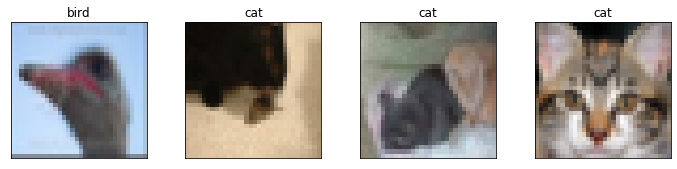

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [ ]:
### how to use GPU with pytorch

# based on https://medium.com/@calincan2000/using-cuda-pytorch-runtimeerror-expected-object-of-backend-cuda-but-got-backend-cpu-running-on-72648b0d6087

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(device)
net=net.to(device)
print(net)


cuda:0
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [22]:
%%time
import os

model_directory_path = './model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'
net=net.to(device)

if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    # load trained model parameters from disk
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            outputs=outputs.cuda()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 1000 == 999:    # print every 1000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0
    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')

[1,  1000] loss: 0.930
[1,  2000] loss: 0.945
[1,  3000] loss: 0.934
[1,  4000] loss: 0.993
[1,  5000] loss: 0.983
[1,  6000] loss: 0.958
[1,  7000] loss: 0.954
[1,  8000] loss: 0.990
[1,  9000] loss: 0.978
[1, 10000] loss: 0.997
[1, 11000] loss: 0.993
[1, 12000] loss: 0.981
[2,  1000] loss: 0.870
[2,  2000] loss: 0.897
[2,  3000] loss: 0.907
[2,  4000] loss: 0.915
[2,  5000] loss: 0.905
[2,  6000] loss: 0.906
[2,  7000] loss: 0.928
[2,  8000] loss: 0.959
[2,  9000] loss: 0.939
[2, 10000] loss: 0.945
[2, 11000] loss: 0.928
[2, 12000] loss: 0.945
[3,  1000] loss: 0.819
[3,  2000] loss: 0.816
[3,  3000] loss: 0.857
[3,  4000] loss: 0.867
[3,  5000] loss: 0.880
[3,  6000] loss: 0.891
[3,  7000] loss: 0.898
[3,  8000] loss: 0.894
[3,  9000] loss: 0.894
[3, 10000] loss: 0.900
[3, 11000] loss: 0.919
[3, 12000] loss: 0.869
[4,  1000] loss: 0.829
[4,  2000] loss: 0.767
[4,  3000] loss: 0.807
[4,  4000] loss: 0.822
[4,  5000] loss: 0.864
[4,  6000] loss: 0.854
[4,  7000] loss: 0.856
[4,  8000] 

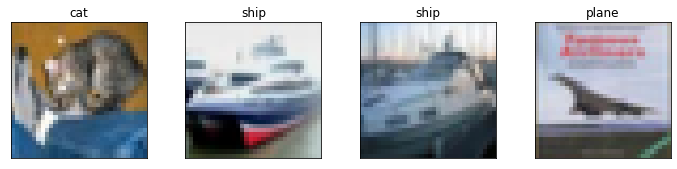

In [23]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [24]:
# outputs = net(images) # RuntimeError: Expected object of backend CPU but got backend CUDA for argument #2 'weight'
outputs= net(images.cuda())

In [25]:
outputs

tensor([[-2.4122, -2.5262,  0.3204,  3.9935, -0.7203,  3.9835,  1.0432, -1.1301,
         -1.2376, -2.2843],
        [ 2.1606,  5.1458, -3.5300, -2.5213, -7.6750, -5.0184, -0.2317, -5.4770,
         12.4115, -1.0574],
        [ 1.8438,  1.6145, -1.6973, -0.1652, -1.3020, -1.2579, -2.5911, -2.4790,
          3.2686,  1.8956],
        [ 4.9121,  2.2871, -1.1385, -1.1219, -2.7794, -1.0323, -1.0469, -3.5213,
          3.1212,  1.3860]], grad_fn=<AddmmBackward>)

In [32]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
print(sm_outputs)

tensor([[9.1627e-04, 3.1947e-03, 3.2989e-02, 5.0263e-01, 6.6262e-02, 1.2460e-01,
         2.5442e-01, 1.0682e-02, 1.8788e-03, 2.4264e-03],
        [2.5409e-02, 1.2123e-03, 3.1458e-02, 1.1834e-01, 3.2183e-04, 3.7588e-01,
         6.3157e-03, 4.3166e-01, 1.0312e-03, 8.3772e-03],
        [2.6806e-02, 5.9342e-01, 1.1317e-02, 3.9755e-02, 8.8267e-02, 2.7265e-02,
         5.8082e-03, 6.9471e-02, 8.2318e-04, 1.3707e-01],
        [3.7722e-06, 4.2900e-06, 1.2179e-03, 1.0019e-03, 1.6060e-02, 7.8222e-03,
         7.5201e-04, 9.7314e-01, 8.4278e-09, 1.3785e-06]])


In [33]:
probs, index = torch.max(sm_outputs, dim=1)
for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

cat - 0.5026
horse - 0.4317
car - 0.5934
horse - 0.9731


In [34]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images=images.cuda()
        outputs = net(images).cuda()
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 63.91%


In [35]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 57.1
car        - 77.6
bird       - 48.8
cat        - 43.0
deer       - 62.1
dog        - 57.7
frog       - 68.7
horse      - 66.2
ship       - 82.2
truck      - 75.7


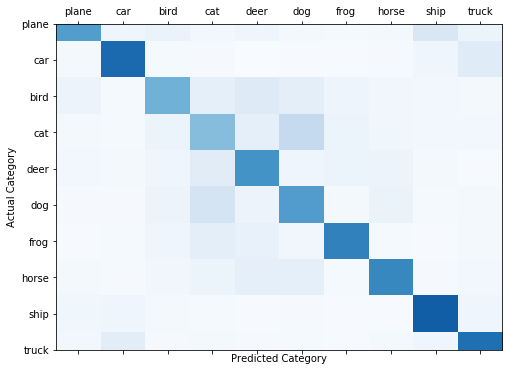

In [36]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [31]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           571       42        64        25        42        18        12        17        150       59        
                0.571     0.042     0.064     0.025     0.042     0.018     0.012     0.017     0.15      0.059     
car             16        776       12        11        3         7         6         8         41        120       
                0.016     0.776     0.012     0.011     0.003     0.007     0.006     0.008     0.041     0.12      
bird            57        13        488       90        122       98        48        33        30        21        
                0.057     0.013     0.488     0.09      0.122     0.098     0.048     0.033     0.03      0.021     
cat             18        14        54        430       90        250       51        37        25        31        
                0.018     0.014     0.054     0.43      0.09    